# GoogLeNet

- Paper: [2014.09.17] Going deeper with convolutions
- https://arxiv.org/abs/1409.4842

### [Package load]

In [1]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
pytorch version: 2.2.2
GPU 사용 가능 여부: False


### [Model: GoogLeNet]

https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py

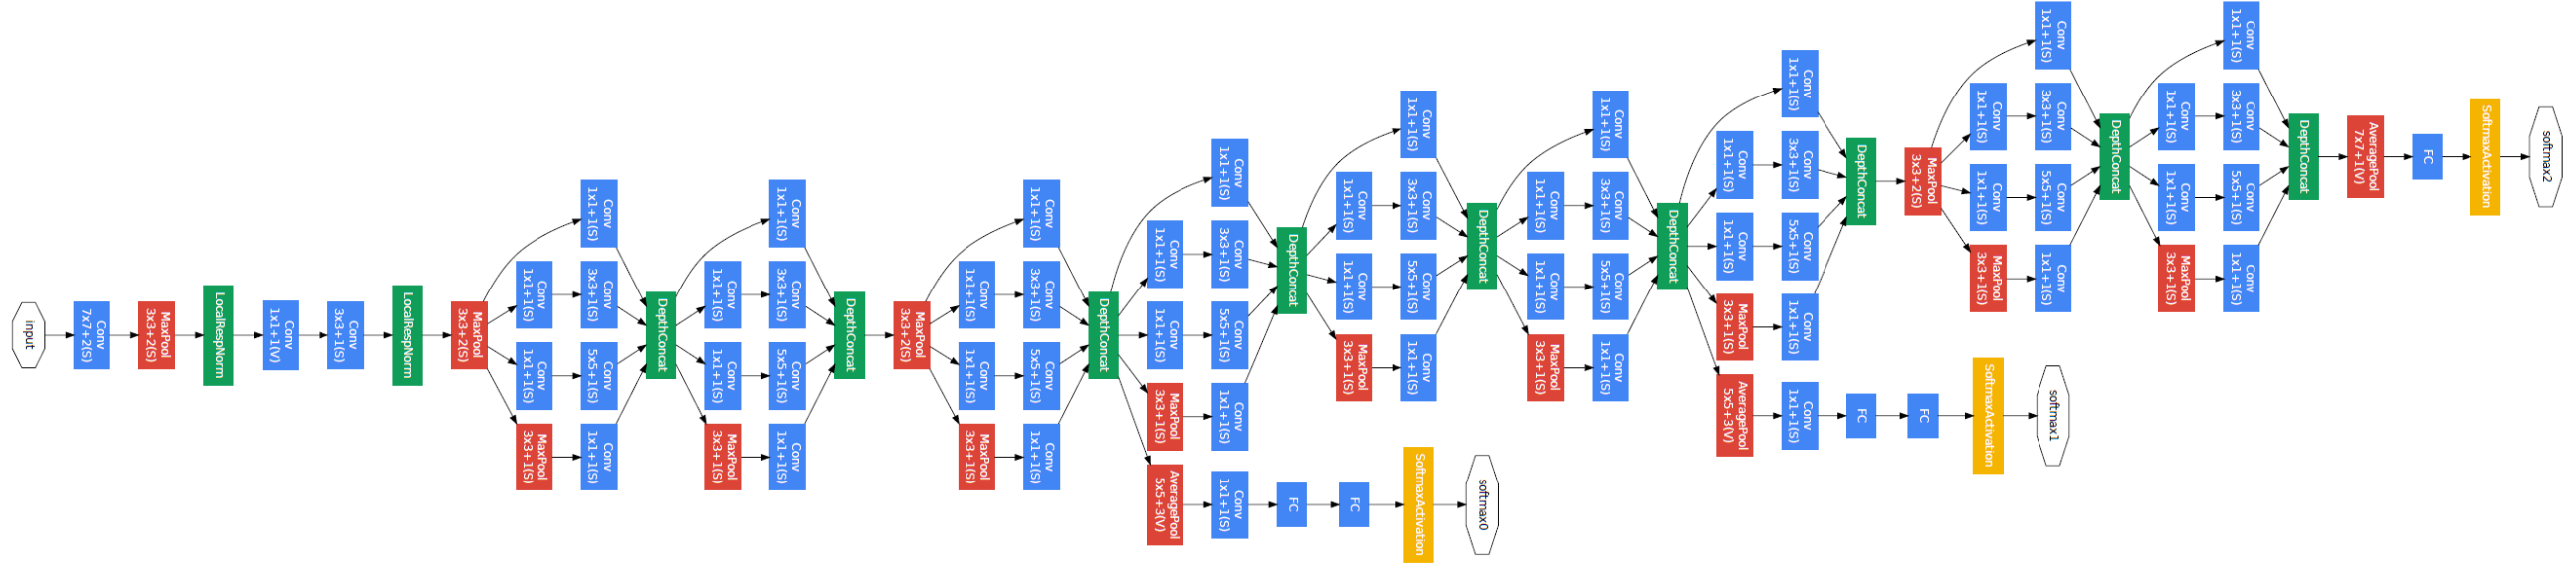

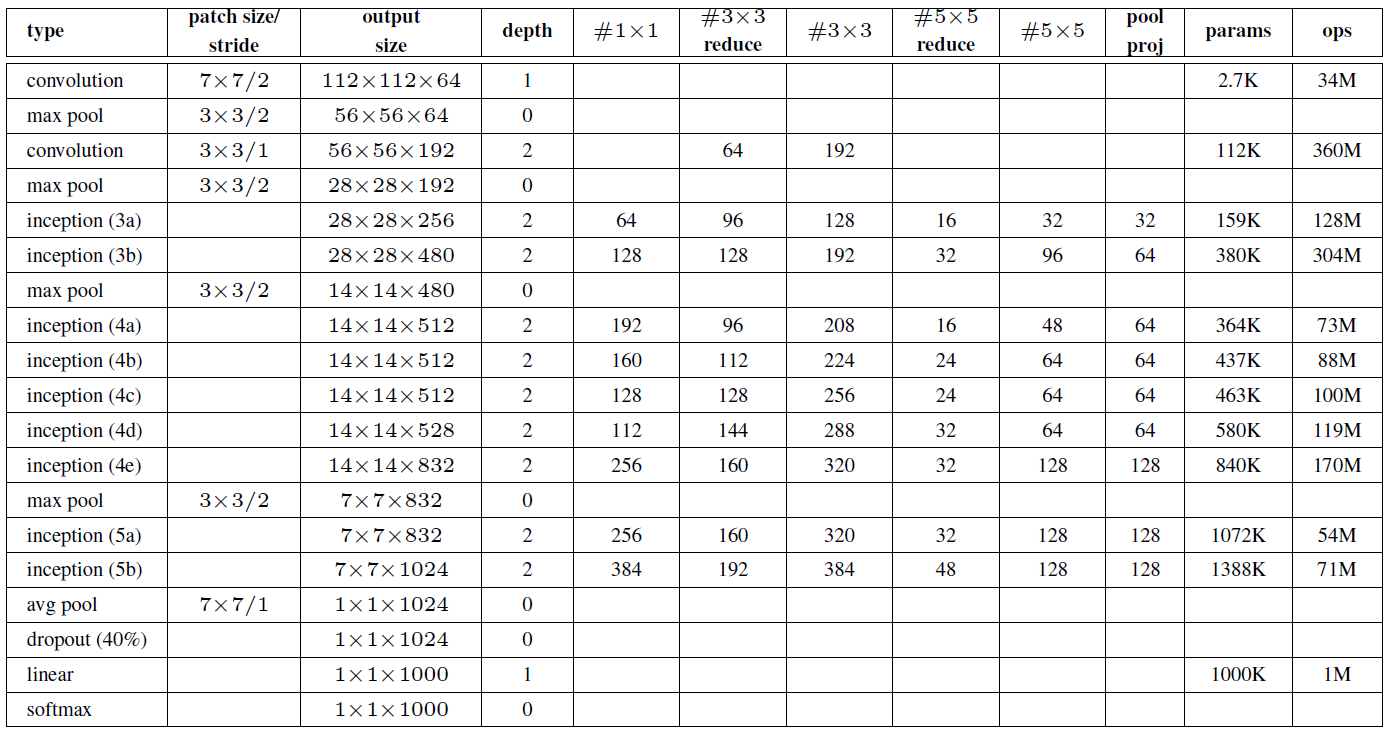

In [9]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes = 1000, aux_logits = True, init_weights = None, blocks = None, dropout = 0.2, dropout_aux = 0.7):
        super().__init__()
        if blocks is None:
            blocks = [BasicConv2d, Inception, InceptionAux]
        if len(blocks) != 3:
            raise ValueError(f"blocks length should be 3 instead of {len(blocks)}")
        conv_block = blocks[0]
        inception_block = blocks[1]
        inception_aux_block = blocks[2]

        self.aux_logits = aux_logits

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = inception_aux_block(512, num_classes, dropout=dropout_aux)
            self.aux2 = inception_aux_block(528, num_classes, dropout=dropout_aux)
        else:
            self.aux1 = None
            self.aux2 = None

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        aux1 = None
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        aux2 = None
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux1, aux2

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj, conv_block=None):
            # ch1x1: 1x1의 channel 수
            # ch3x3red: ch3x3 전에 channel reduction 위한 1x1 층의 channel 수를 의미
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1), conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1),
        )

    def _forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)
        # Concatenation 시키기


class InceptionAux(nn.Module):
    # Auxiliary가 있는 module
    def __init__(self, in_channels, num_classes, conv_block = None, dropout = 0.7):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)                # 1x1 conv 통과
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)         # flatten 후 FC layer 통과
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = self.dropout(x)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        # **kwargs: kernel size 등 위해서
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [10]:
googlenet = GoogleNet(num_classes=4).to(device)
# OCT classification에서 class 4개이므로 4를 대입

In [11]:
googlenet

GoogleNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
googlenet(temp)

(tensor([[ 0.3753, -0.0247,  0.2403,  0.1771]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.2760, -0.2101, -0.6088, -0.2812]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.2213,  0.2349,  0.1931, -0.1350]], grad_fn=<AddmmBackward0>))

In [13]:
from torchsummary import summary
summary(googlenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [15]:
from torchinfo import summary
summary(googlenet, input_size=(1, 3, 224, 224), col_width=20, depth=100, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)             Input Shape          Kernel Shape         Output Shape         Param %
GoogleNet (GoogleNet)                         [1, 3, 224, 224]     --                   [1, 4]                43.63%
├─BasicConv2d (conv1): 1-1                    [1, 3, 224, 224]     --                   [1, 64, 112, 112]         --
│    └─Conv2d (conv): 2-1                     [1, 3, 224, 224]     [7, 7]               [1, 64, 112, 112]      0.09%
│    └─BatchNorm2d (bn): 2-2                  [1, 64, 112, 112]    --                   [1, 64, 112, 112]      0.00%
├─MaxPool2d (maxpool1): 1-2                   [1, 64, 112, 112]    3                    [1, 64, 56, 56]           --
├─BasicConv2d (conv2): 1-3                    [1, 64, 56, 56]      --                   [1, 64, 56, 56]           --
│    └─Conv2d (conv): 2-3                     [1, 64, 56, 56]      [1, 1]               [1, 64, 56, 56]        0.04%
│    └─BatchNorm2d (bn): 2-4                  [1, 64, 56, 56]   